In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from imodels import RuleFitClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from rulefit import RuleFit
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, export_text
from collections import Counter
import warnings
warnings.filterwarnings("ignore")



DATA OVERVIEW

In [2]:
data = pd.read_csv('onlinefoods.csv')
data = data.drop('Unnamed: 12',axis=1)
data = data.drop('Output',axis=1)

data.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Feedback
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Positive
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Positive
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Negative
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Positive
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Positive


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         388 non-null    int64  
 1   Gender                      388 non-null    object 
 2   Marital Status              388 non-null    object 
 3   Occupation                  388 non-null    object 
 4   Monthly Income              388 non-null    object 
 5   Educational Qualifications  388 non-null    object 
 6   Family size                 388 non-null    int64  
 7   latitude                    388 non-null    float64
 8   longitude                   388 non-null    float64
 9   Pin code                    388 non-null    int64  
 10  Feedback                    388 non-null    object 
dtypes: float64(2), int64(3), object(6)
memory usage: 33.5+ KB


In [4]:
data.isnull().sum()

Age                           0
Gender                        0
Marital Status                0
Occupation                    0
Monthly Income                0
Educational Qualifications    0
Family size                   0
latitude                      0
longitude                     0
Pin code                      0
Feedback                      0
dtype: int64

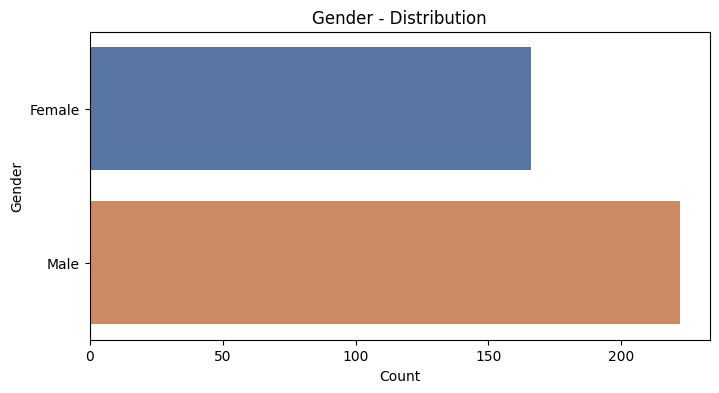

In [5]:
plt.figure(figsize=(8, 4), dpi=100)
sns.countplot(y='Gender', data=data, hue='Gender', palette='deep', legend=False)
plt.title("Gender - Distribution")
plt.xlabel("Count")
plt.ylabel("Gender")
plt.show()

In [6]:
max_age = max(data['Age'])
min_age = min(data['Age'])
print(min_age)
print(max_age)

18
33


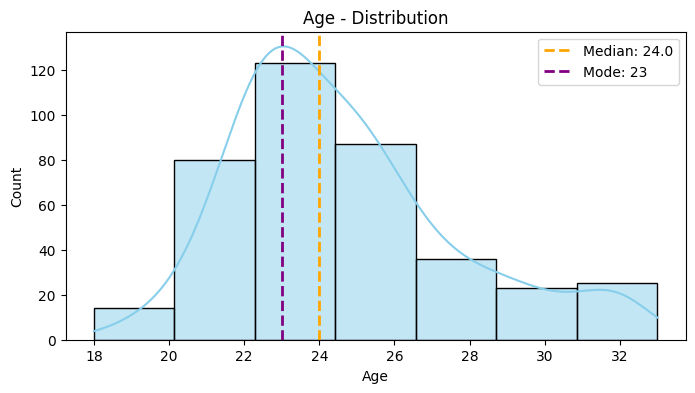

In [7]:
median_age = data['Age'].median()
mode_age = data['Age'].mode()[0]  

plt.figure(figsize=(8, 4), dpi=100)
sns.histplot(data['Age'], bins=7, kde=True, color="skyblue")
plt.axvline(median_age, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_age}')
plt.axvline(mode_age, color='purple', linestyle='--', linewidth=2, label=f'Mode: {mode_age}')
plt.title("Age - Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.show()

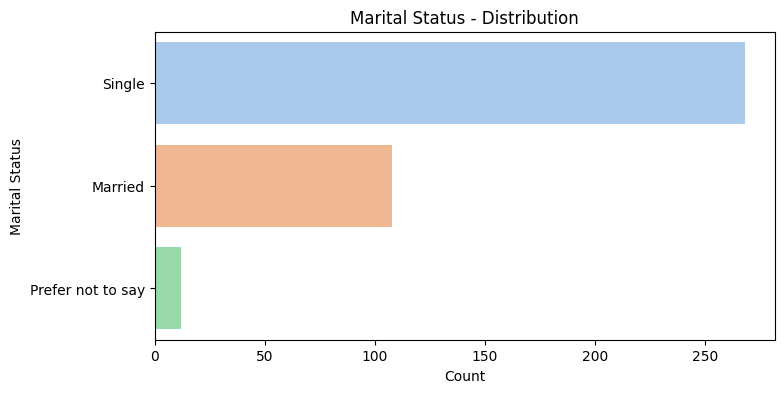

In [8]:
plt.figure(figsize=(8, 4), dpi=100)
sns.countplot(y='Marital Status', data=data, hue='Marital Status', palette='pastel', legend=False)
plt.title("Marital Status - Distribution")
plt.xlabel("Count")
plt.ylabel("Marital Status")
plt.show()

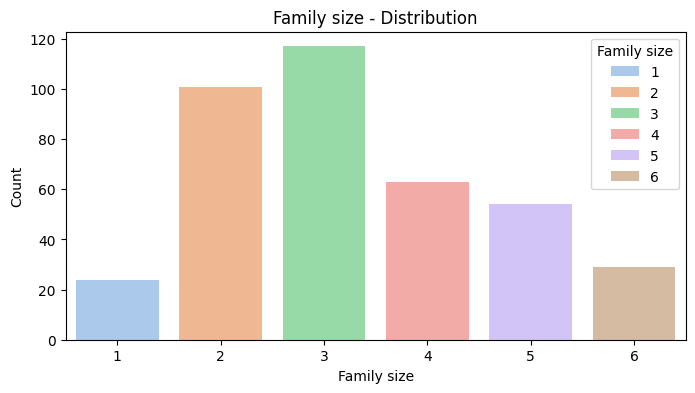

In [9]:
plt.figure(figsize=(8, 4), dpi=100)
sns.countplot(x='Family size', data=data, hue='Family size', palette='pastel', dodge=False)
plt.title("Family size - Distribution")
plt.ylabel("Count")
plt.xlabel("Family size")
plt.show()

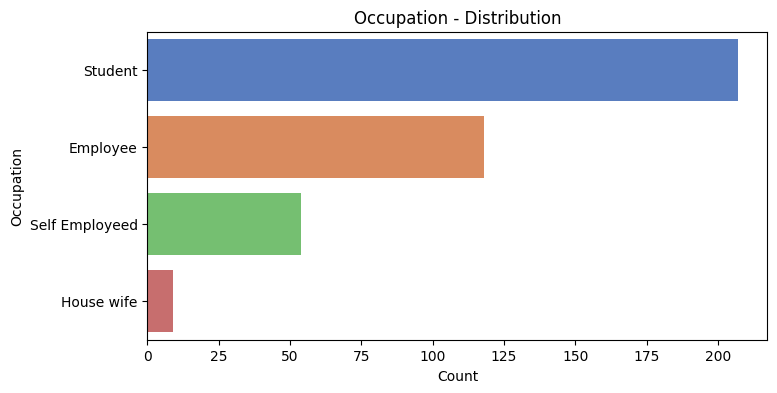

In [10]:
plt.figure(figsize=(8, 4), dpi=100)
sns.countplot(y='Occupation', data=data, hue='Occupation', palette='muted', legend=False)
plt.title("Occupation - Distribution")
plt.xlabel("Count")
plt.ylabel("Occupation")
plt.show()

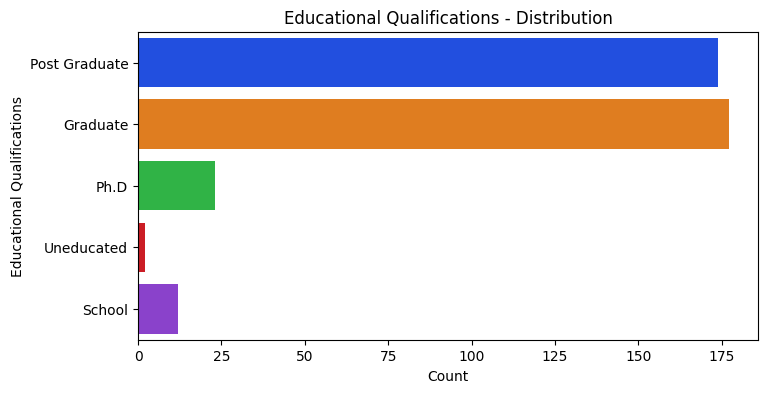

In [11]:
plt.figure(figsize=(8, 4), dpi=100)
sns.countplot(y='Educational Qualifications', data=data, hue='Educational Qualifications', palette='bright', legend=False)
plt.title("Educational Qualifications - Distribution")
plt.xlabel("Count")
plt.ylabel("Educational Qualifications")
plt.show()

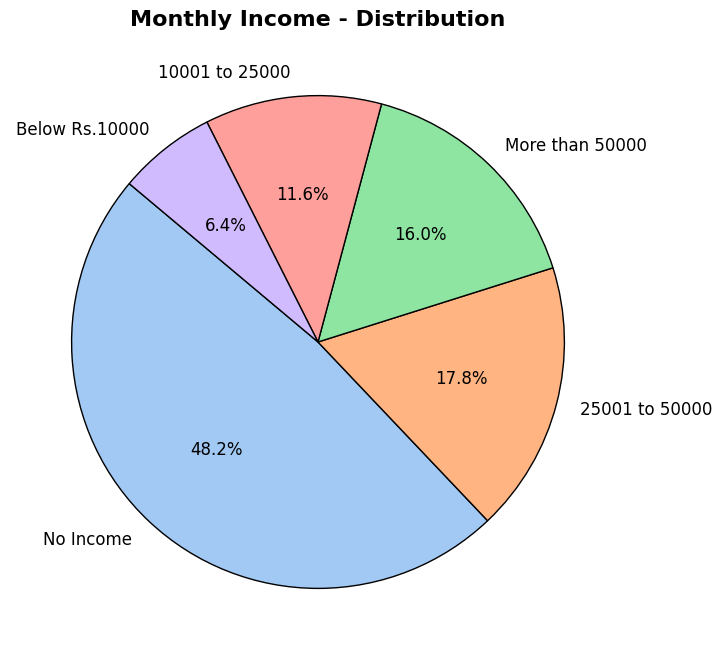

In [12]:

income_counts = data['Monthly Income'].value_counts()

colors = sns.color_palette("pastel")
plt.figure(figsize=(10, 8), dpi=100)
plt.pie(income_counts, labels=income_counts.index, autopct='%1.1f%%', startangle=140,
        colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth': 1}, textprops={'fontsize': 12})
plt.title("Monthly Income - Distribution", fontsize=16, fontweight='bold')

plt.show()


In [13]:
fig = px.scatter_geo(
    data, 
    lat='latitude', 
    lon='longitude', 
    text='Pin code', 
    title='Geographical Chart with Pincodes'
)

# Show the plot
fig.show()

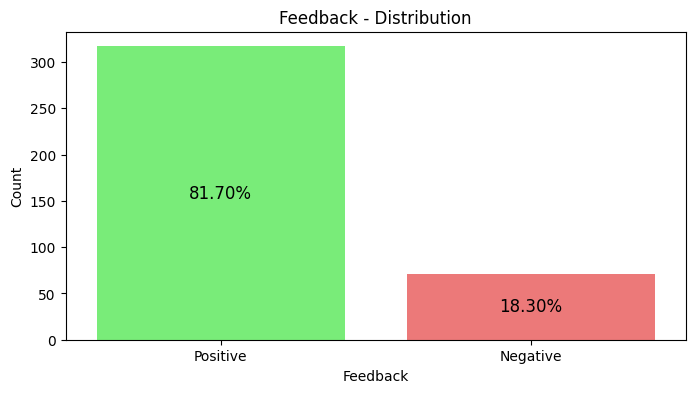

In [14]:
data['Feedback'] = data['Feedback'].str.strip()

feedback_palette = {'Positive': '#66ff66', 'Negative': '#ff6666'}

plt.figure(figsize=(8, 4), dpi=100)
ax = sns.countplot(x='Feedback', data=data, hue='Feedback', palette=feedback_palette, dodge=False)

total = len(data)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height / 2),
                ha='center', va='center', fontsize=12, color='black')

plt.title("Feedback - Distribution")
plt.ylabel("Count")
plt.xlabel("Feedback")
plt.show()

DATA PREPROSESSING

 Make Ordinal Columns Numerical

In [15]:
income_order = [
    'No Income', 
    'Below Rs.10000', 
    '10001 to 25000', 
    '25001 to 50000', 
    'More than 50000'
]
data['Monthly Income'] = pd.Categorical(data['Monthly Income'], categories=income_order, ordered=True)
data['Monthly Income Ordinal'] = data['Monthly Income'].cat.codes
data = data.drop('Monthly Income',axis=1)


educational_order = [
    'Uneducated', 
    'School', 
    'Graduate', 
    'Post Graduate', 
    'Ph.D'
]

data['Educational Qualifications'] = pd.Categorical(data['Educational Qualifications'], categories=educational_order, ordered=True)
data['Educational Qualifications Ordinal'] = data['Educational Qualifications'].cat.codes
data = data.drop('Educational Qualifications',axis=1)


data.head(10)

,Age,Gender,Marital Status,Occupation,Family size,latitude,longitude,Pin code,Feedback,Monthly Income Ordinal,Educational Qualifications Ordinal
0,20,Female,Single,Student,4,12.9766,77.5993,560001,Positive,0,3
1,24,Female,Single,Student,3,12.9770,77.5773,560009,Positive,1,2
2,22,Male,Single,Student,3,12.9551,77.6593,560017,Negative,1,3
3,22,Female,Single,Student,6,12.9473,77.5616,560019,Positive,0,2
4,22,Male,Single,Student,4,12.9850,77.5533,560010,Positive,1,3
5,27,Female,Married,Employee,2,12.9299,77.6848,560103,Positive,4,3
6,22,Male,Single,Student,3,12.9770,77.5773,560009,Positive,0,2
7,24,Female,Single,Student,3,12.9828,77.6131,560042,Positive,0,3
8,23,Female,Single,Student,2,12.9766,77.5993,560001,Positive,0,3
9,23,Female,Single,Student,4,12.9854,77.7081,560048,Positive,0,3


 Make Nominal Columns Numerical

In [16]:
data['Gender'], Gender_uniques = pd.factorize(data['Gender'])
data['Feedback'] = np.where(data['Feedback'] == 'Positive', 1, 0)


data = pd.get_dummies(data, columns=['Occupation'])
data = pd.get_dummies(data, columns=['Marital Status'])

data.head(10)

,Age,Gender,Family size,latitude,longitude,Pin code,Feedback,Monthly Income Ordinal,Educational Qualifications Ordinal,Occupation_Employee,Occupation_House wife,Occupation_Self Employeed,Occupation_Student,Marital Status_Married,Marital Status_Prefer not to say,Marital Status_Single
0,20,0,4,12.9766,77.5993,560001,1,0,3,False,False,False,True,False,False,True
1,24,0,3,12.9770,77.5773,560009,1,1,2,False,False,False,True,False,False,True
2,22,1,3,12.9551,77.6593,560017,0,1,3,False,False,False,True,False,False,True
3,22,0,6,12.9473,77.5616,560019,1,0,2,False,False,False,True,False,False,True
4,22,1,4,12.9850,77.5533,560010,1,1,3,False,False,False,True,False,False,True
5,27,0,2,12.9299,77.6848,560103,1,4,3,True,False,False,False,True,False,False
6,22,1,3,12.9770,77.5773,560009,1,0,2,False,False,False,True,False,False,True
7,24,0,3,12.9828,77.6131,560042,1,0,3,False,False,False,True,False,False,True
8,23,0,2,12.9766,77.5993,560001,1,0,3,False,False,False,True,False,False,True
9,23,0,4,12.9854,77.7081,560048,1,0,3,False,False,False,True,False,False,True


TRAIN AND TEST MODELS

DT - Gini

Best parameters from cross-validation:
{'max_depth': 3, 'min_samples_leaf': 3}

Best cross-validation score:
0.8065

Cross-validation scores for each fold:
Fold 1: 0.8065
Fold 2: 0.7903
Fold 3: 0.8387
Fold 4: 0.7903
Fold 5: 0.8065

Mean cross-validation accuracy:
0.8065
------------------------------

Test Metrics:
DTree (Gini) Accuracy: 0.7692
DTree (Gini) Precision: 0.5237
DTree (Gini) Recall: 0.5237
DTree (Gini) F1-Score: 0.5237


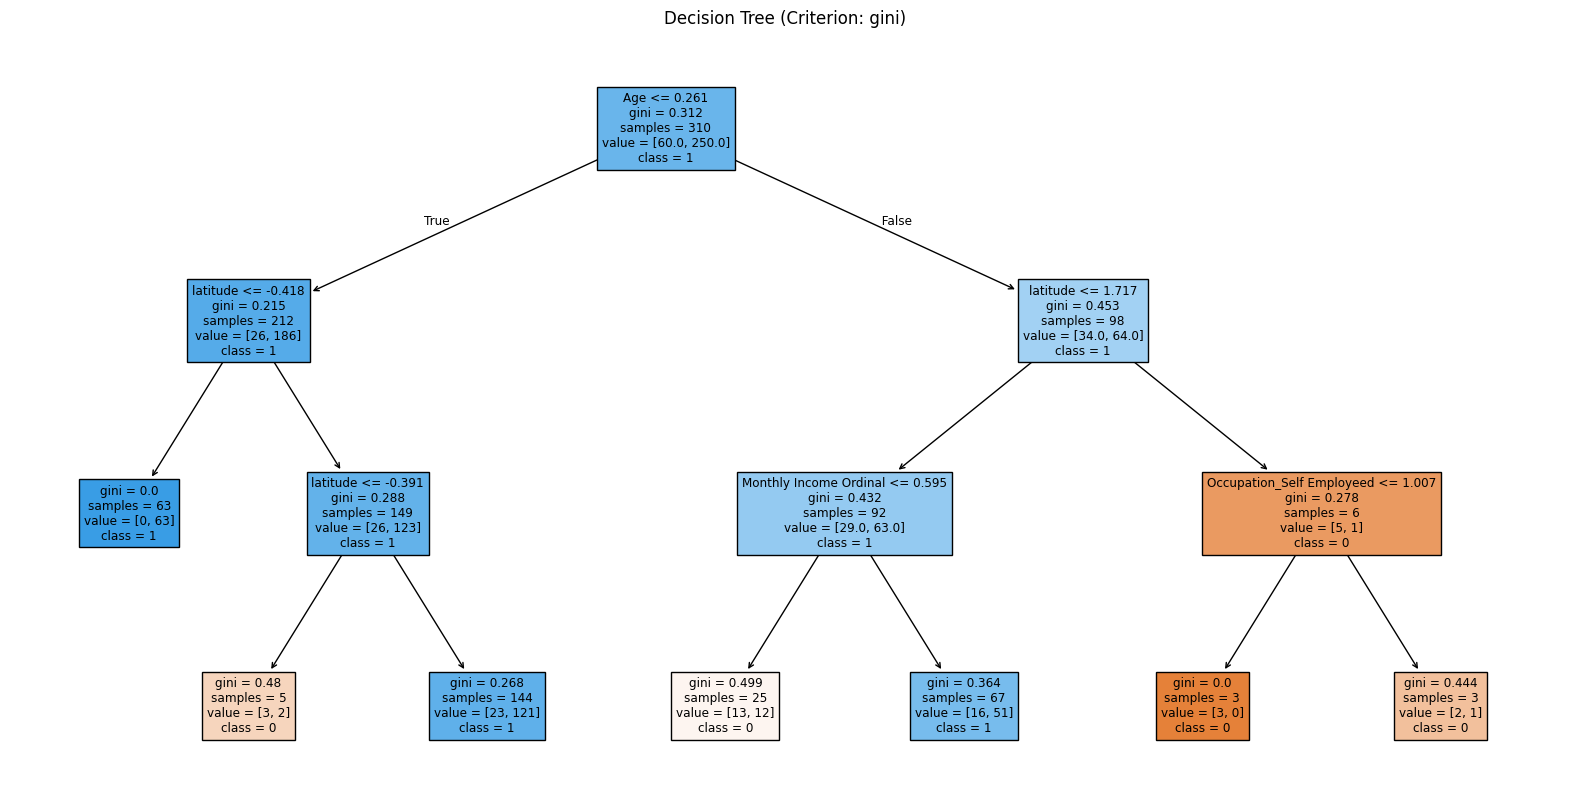

In [17]:
# Split data into features and labels
X = data.drop('Feedback', axis=1).values 
y = data['Feedback'].values  

# Split into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

# Set up parameters for grid search
params = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 4]
}

# Initialize classifier
clf = DecisionTreeClassifier()

# Set up cross-validation scheme
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(clf, params, cv=skf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_full_scaled, y_train_full)

# Print best parameters and cross-validation score
print("Best parameters from cross-validation:")
print(grid_search.best_params_)
print("\nBest cross-validation score:")
print(f"{grid_search.best_score_:.4f}")

# Best estimator from grid search
best_clf = grid_search.best_estimator_

# Cross-validation scores for the best estimator
fold_accuracies = cross_val_score(best_clf, X_train_full_scaled, y_train_full, cv=skf)
print("\nCross-validation scores for each fold:")
for i, score in enumerate(fold_accuracies, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"\nMean cross-validation accuracy:\n{fold_accuracies.mean():.4f}")

# Dashed line for separation
print("-" * 30)

# Predictions on test set
y_pred = best_clf.predict(X_test_scaled)

# Calculate and print test metrics
print("\nTest Metrics:")
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro')
test_recall = recall_score(y_test, y_pred, average='macro')
test_f1 = f1_score(y_test, y_pred, average='macro')

print(f"DTree (Gini) Accuracy: {test_accuracy:.4f}")
print(f"DTree (Gini) Precision: {test_precision:.4f}")
print(f"DTree (Gini) Recall: {test_recall:.4f}")
print(f"DTree (Gini) F1-Score: {test_f1:.4f}")

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_clf, filled=True, feature_names=data.drop('Feedback', axis=1).columns, 
          class_names=[str(cls) for cls in best_clf.classes_], impurity=True)
plt.title(f"Decision Tree (Criterion: {best_clf.criterion})")
plt.show()



DT - Entropy

DTree (Entropy) Accuracy: 0.8205
DTree (Entropy) Precision: 0.6087
DTree (Entropy) Recall: 0.5916
DTree (Entropy) F1-Score: 0.5985


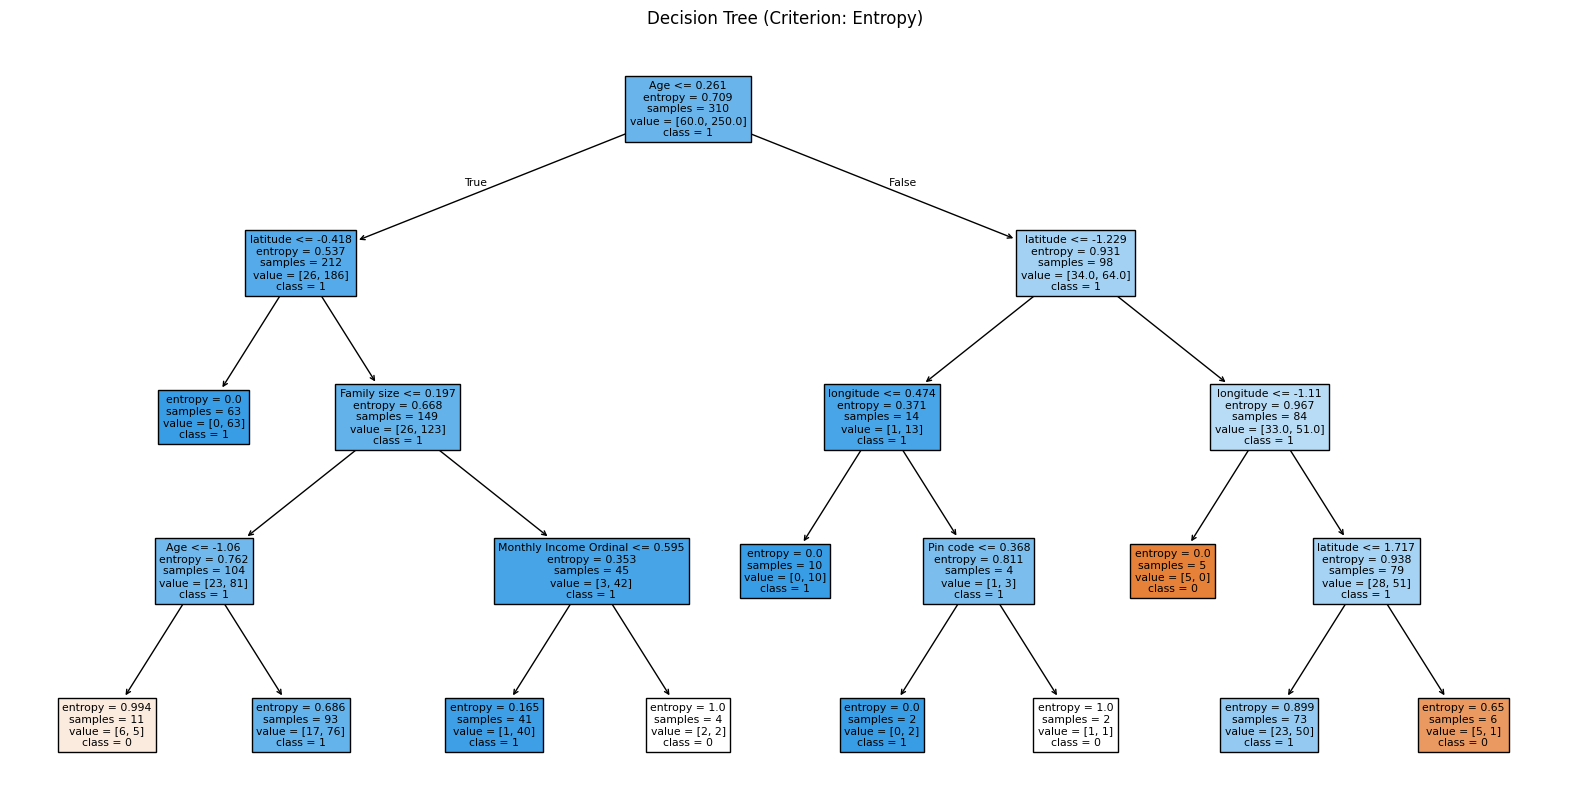

In [18]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split data into features and labels
X = data.drop('Feedback', axis=1).values 
y = data['Feedback'].values  

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree classifier with Entropy criterion
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=2)  # Set max_depth and min_samples_leaf as desired

# Train the model on the training set
clf.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = clf.predict(X_test_scaled)

# Calculate and print test metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro')
test_recall = recall_score(y_test, y_pred, average='macro')
test_f1 = f1_score(y_test, y_pred, average='macro')

print(f"DTree (Entropy) Accuracy: {test_accuracy:.4f}")
print(f"DTree (Entropy) Precision: {test_precision:.4f}")
print(f"DTree (Entropy) Recall: {test_recall:.4f}")
print(f"DTree (Entropy) F1-Score: {test_f1:.4f}")

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=data.drop('Feedback', axis=1).columns, 
          class_names=[str(cls) for cls in clf.classes_], 
          impurity=True)  # impurity=True to show the Entropy criterion
plt.title("Decision Tree (Criterion: Entropy)")
plt.show()


DT - Information Gain

In [19]:
def entropy(y):
    class_counts = Counter(y)
    total_count = len(y)
    entropy_value = 0
    for count in class_counts.values():
        prob = count / total_count
        entropy_value -= prob * np.log2(prob)
    return entropy_value

def information_gain(X, y, feature_index):
    total_entropy = entropy(y)
    values = np.unique(X[:, feature_index])
    weighted_entropy = 0
    for value in values:
        subset_y = y[X[:, feature_index] == value]
        weighted_entropy += len(subset_y) / len(y) * entropy(subset_y)
    return total_entropy - weighted_entropy

def best_split(X, y):
    best_gain = -1
    best_feature = -1
    for feature_index in range(X.shape[1]):
        gain = information_gain(X, y, feature_index)
        if gain > best_gain:
            best_gain = gain
            best_feature = feature_index
    return best_feature

class ID3DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None
        self.feature_names = None

    def fit(self, X, y, feature_names, depth=0):
        self.feature_names = feature_names
        if len(np.unique(y)) == 1:
            return np.unique(y)[0]
        
        if self.max_depth is not None and depth >= self.max_depth:
            return np.unique(y)[np.argmax(np.bincount(y))]

        best_feature = best_split(X, y)
        tree = {best_feature: {}}
        
        values = np.unique(X[:, best_feature])
        for value in values:
            subset_X = X[X[:, best_feature] == value]
            subset_y = y[X[:, best_feature] == value]
            
            if len(subset_y) == 0:
                continue
            
            tree[best_feature][value] = self.fit(subset_X, subset_y, feature_names, depth + 1)
        
        self.tree = tree
        return tree
    
    def predict(self, X):
        return [self._predict_one(sample) for sample in X]
    
    def _predict_one(self, sample):
        tree = self.tree
        while isinstance(tree, dict):
            feature = list(tree.keys())[0]
            value = sample[feature]
            tree = tree[feature].get(value, None)
        return tree if tree is not None else 0

X = data.drop('Feedback', axis=1).values
y = data['Feedback'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = ID3DecisionTree(max_depth=4)

model.fit(X_train_scaled, y_train, feature_names=data.drop('Feedback', axis=1).columns)

y_pred = model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro')
test_recall = recall_score(y_test, y_pred, average='macro')
test_f1 = f1_score(y_test, y_pred, average='macro')

print(f"DTree (Information Gain) Accuracy: {test_accuracy:.4f}")
print(f"DTree (Information Gain) Precision: {test_precision:.4f}")
print(f"DTree (Information Gain) Recall: {test_recall:.4f}")
print(f"DTree (Information Gain) F1-Score: {test_f1:.4f}")


DTree (Information Gain) Accuracy: 0.7308
DTree (Information Gain) Precision: 0.6088
DTree (Information Gain) Recall: 0.6913
DTree (Information Gain) F1-Score: 0.6132


NB

In [20]:
X = data.drop('Feedback', axis=1).values
y = data['Feedback'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = GaussianNB()
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"NB Accuracy: {accuracy:.4f}")
print(f"NB Precision: {precision:.4f}")
print(f"NB Recall: {recall:.4f}")
print(f"NB F1-Score: {f1:.4f}")

NB Accuracy: 0.8077
NB Precision: 0.6136
NB Recall: 0.6221
NB F1-Score: 0.6175


Rull-Based

In [21]:
# بارگذاری دادهها
X = data.drop('Feedback', axis=1)
y = data['Feedback']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# آموزش مدل درخت تصمیم
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# پیشبینی
y_pred = model.predict(X_test)

# محاسبه معیارها
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# نمایش قوانین
rules = export_text(model, feature_names=list(X.columns))

print(f"RB Accuracy: {accuracy}")
print(f"RB Precision: {precision}")
print(f"RB Recall: {recall}")
print(f"RB F1-Score: {f1}")
print("-------------------------------------------------------------------")
print("Rules:")
print(rules)

RB Accuracy: 0.7564102564102564
RB Precision: 0.5685483870967742
RB Recall: 0.5922659430122117
RB F1-Score: 0.5745047372954349
-------------------------------------------------------------------
Rules:
|--- Age <= 25.50
|   |--- latitude <= 12.95
|   |   |--- class: 1
|   |--- latitude >  12.95
|   |   |--- latitude <= 12.96
|   |   |   |--- Occupation_Student <= 0.50
|   |   |   |   |--- Marital Status_Married <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Marital Status_Married >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Occupation_Student >  0.50
|   |   |   |   |--- class: 0
|   |   |--- latitude >  12.96
|   |   |   |--- Age <= 21.50
|   |   |   |   |--- Family size <= 3.50
|   |   |   |   |   |--- Gender <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Gender >  0.50
|   |   |   |   |   |   |--- Pin code <= 560032.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Pin code >  560032.00
|   |   |   |   |  